<a href="https://colab.research.google.com/github/RGologorsky/fastproj/blob/master/Image_Segmentation_Hair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: label pixels with hair

## Imports

In [0]:
%matplotlib inline

In [0]:
%%capture
!pip install fastai2

In [0]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [4]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# utils
def pp_list(l): print(f"len {len(l)}:", *l, sep="\n")

In [6]:
pp_list(range(2))

len 2:
0
1


## Load Data (unzip if needed)

In [0]:
base_path = Path("drive/My Drive/fastai_proj")
proj = "segmentation"

In [10]:
proj_path = base_path/proj
pp_list(proj_path.ls())

len 2:
drive/My Drive/fastai_proj/segmentation/face_segment_data_sampleset.zip
drive/My Drive/fastai_proj/segmentation/data


In [0]:
data_src = proj_path/"face_segment_data_sampleset.zip"
data_dest = proj_path/"data"

In [0]:
# !unzip -qq "$data_src" -d "$data_dest"

## View data w/labels

In [0]:
path_lbl = data_dest/"labels"
path_img = data_dest

In [16]:
# list of labeled image filenames
lbl_names = get_image_files(path_lbl)
pp_list(lbl_names[:3])

len 3:
drive/My Drive/fastai_proj/segmentation/data/labels/femalemira/headrende0002.png
drive/My Drive/fastai_proj/segmentation/data/labels/femalemira/headrende0062.png
drive/My Drive/fastai_proj/segmentation/data/labels/femalemira/headrende0140.png


In [0]:
# look for images in all folders except for "labels"
# def rm_parent_path(f): return re.search("(?!.*\/).*", str(f)).group(0)

def rm_path_prefix(f, prefix=path_img): return str(f).replace(f"{prefix}/", "")
img_folders = [rm_path_prefix(p) for p in path_img.ls() if p != path_lbl]

In [18]:
# list of training image filenames
fnames = get_image_files(data_dest, recurse=True, folders=img_folders)
pp_list(fnames[:3])

len 3:
drive/My Drive/fastai_proj/segmentation/data/malekumar_env01/headrende0003.png
drive/My Drive/fastai_proj/segmentation/data/malekumar_env01/headrende0024.png
drive/My Drive/fastai_proj/segmentation/data/malekumar_env01/headrende0042.png


### Define y: training image fname -> labelled image fname

In [0]:
def cutoff_underscore(x): return re.search("([^_])*(?=\/)", str(x)).group(0)
get_y_fn = lambda x: path_lbl/cutoff_underscore(rm_path_prefix(x))/x.name

In [111]:
pp_list([fnames[0], get_y_fn(fnames[0])])

len 2:
drive/My Drive/fastai_proj/segmentation/data/malekumar_env01/headrende0003.png
drive/My Drive/fastai_proj/segmentation/data/labels/env01/headrende0003.png


In [112]:
test_str = "drive/My Drive/fastai_proj/segmentation/data/femalemei_blackhair_browneyes/headrende0102.png'"
pp_list([test_str, get_y_fn(Path(test_str))])

len 2:
drive/My Drive/fastai_proj/segmentation/data/femalemei_blackhair_browneyes/headrende0102.png'
drive/My Drive/fastai_proj/segmentation/data/labels/browneyes/headrende0102.png'


In [113]:
test_str = 'drive/My Drive/fastai_proj/segmentation/data/real/10400195895_65e5f01518_o_scaled_scaled.jpg'
pp_list([test_str, get_y_fn(Path(test_str))])

len 2:
drive/My Drive/fastai_proj/segmentation/data/real/10400195895_65e5f01518_o_scaled_scaled.jpg
drive/My Drive/fastai_proj/segmentation/data/labels/real/10400195895_65e5f01518_o_scaled_scaled.jpg


## View image/label mask

In [0]:
idx = -1
fname = path_img/"maleandrew2_env01/headrende0240.png"


In [0]:
# training image
img_f = fnames[idx] if idx != -1 else fname
img = PILImage.create(img_f)
#img.show()

In [0]:
# labeled image
img_lbl_f = get_y_fn(img_f)
img_lbl = PILImage.create(img_lbl_f)
# img_lbl.show()

In [0]:
# masked image
mask = PILMask.create(img_lbl_f)
# mask.show()

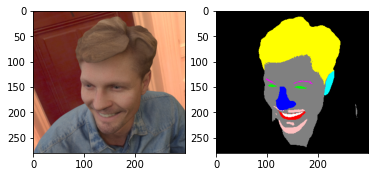

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(img_lbl)
plt.show()

In [50]:
img_lbl_t = tensor(img_lbl)
img_lbl_t.shape #img_lbl_t

(torch.Size([280, 300, 3]),)

In [52]:
mask_t = tensor(mask)
mask_t.shape #mask_t

torch.Size([280, 300])

In [49]:
idx1,idx2 = 200,150
img_lbl_t[idx1,idx2], mask_t[idx1,idx2]

(tensor([255, 192, 192], dtype=torch.uint8), tensor(211, dtype=torch.uint8))

In [54]:
img_lbl_t.unique(),mask_t.unique()

(tensor([  0, 128, 192, 255], dtype=torch.uint8),
 tensor([  0,  29,  76, 105, 128, 150, 179, 211, 226, 255], dtype=torch.uint8))

## Codes found

In [0]:
segm_codes = {
    0: "NA",
    29: "nose",
    76: "mouth",
    105: "eyebrow",
    128: "skin",
    150: "eye",
    179: "ear",
    211: "facial_hair",
    226: "hair",
    255: "teeth",
}

In [90]:
segm_vals = segm_codes.keys()
codes = np.array([str(c) for c in segm_codes.values()])
codes

array(['NA', 'nose', 'mouth', 'eyebrow', 'skin', 'eye', 'ear',
       'facial_hair', 'hair', 'teeth'], dtype='<U11')

In [0]:
# check if file has val missing from segm_codes
def missing_codes(f):
  mask = PILMask.create(img_lbl_f)
  vals = np.unique(mask)
  return (f, [v for v in vals if v not in segm_vals])

In [98]:
missing_codes = [missing_codes(f) for f in lbl_names]


TypeError: ignored

In [0]:
missing_codes = [(f,lst) for (f,lst) in missing_codes if len(lst) > 0]

### Check codes

In [60]:
unique_vals = np.unique(mask)
unique_vals

array([  0,  29,  76, 105, 128, 150, 179, 211, 226, 255], dtype=uint8)

In [0]:
val = 211

In [0]:
orig_mask = mask
orig_img = img_f

In [0]:
mask_arr = np.array(orig_mask)
img_arr = np.array(Image.open(img_f))

In [0]:
# mask_arr.shape, img_arr.shape

In [0]:
mask_arr = np.array(orig_mask)
mask_arr[mask_arr != val] = 0
new_mask = Image.fromarray(mask_arr)
#new_mask


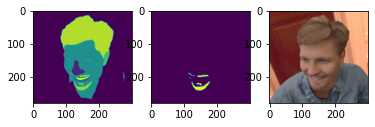

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(mask)
ax2.imshow(new_mask)
ax3.imshow(img)
plt.show()

## Datasets

In [0]:
get_items_fn = lambda x: fnames

In [0]:
db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items = get_items_fn,
    get_y = get_y_fn,
    splitter=RandomSplitter(valid_pct = 0.2, seed=42),
    batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)]
)

In [122]:
dls = db.dataloaders(source = path_img, bs=8, path=data_dest)

FileNotFoundError: ignored

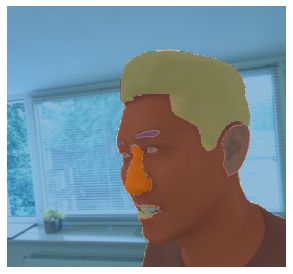

In [118]:
show_at(dls.train_ds, 0)

In [119]:
b = dls.train.one_batch()

FileNotFoundError: ignored